In [201]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import seaborn as sns
from matplotlib.axes import Axes  # noqa
from matplotlib.figure import Figure  # noqa
from plotly.offline import iplot
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [197]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [198]:
plt.style.use('science')
sns.set_theme()

In [199]:
plt.rcParams['figure.figsize'] = (8, 4)

In [7]:
df: pd.DataFrame = pd.read_csv('data/Mall_Customers.csv')
df = df.rename(columns={
    'CustomerID': 'customer_id',
    'Genre': 'gender',
    'Age': 'age',
    'Annual Income (k$)': 'annual_income',
    'Spending Score (1-100)': 'spending_score',
})
df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


В датасете отсутствуют отсутствующие значения:

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     200 non-null    int64 
 1   gender          200 non-null    object
 2   age             200 non-null    int64 
 3   annual_income   200 non-null    int64 
 4   spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Исследуем зависимость между признаками `annual_income` и `spending_score` с помощью визуализации:

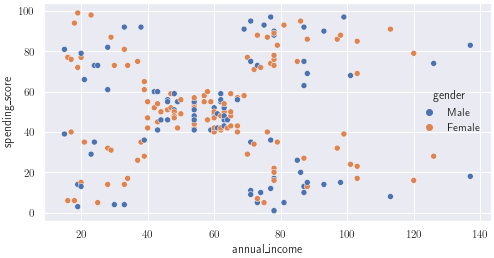

In [17]:
sns.scatterplot(data=df, x='annual_income', y='spending_score', hue='gender');

Хотя линейной зависимости между `annual_income` и `spending_score` нет, можно заметить некоторые скопления данных, которые образуют группы (кластеры). Их можно интерпретировать как: (люди с)
- низкими доходами и низкой долей трат
- низкими доходами и высокой долей трат
- средними доходами и средней долей трат (кажется их большинство)
- высокими доходами и низкой долей трат
- высокими доходами и высокой долей трат

_Дополнительно, можно заметить, что пол не привносит никакой информации, не образуя видимой взаимосвязи ни с одним из рассматриваемых параметров. Т.е. можно сделать, что степень трат и величина дохода никак не зависят от пола._

Визуально удалось выделить `5` кластеров. Попробуем автоматически кластеризовать данные используя метод K-средних.

Предварительно выберем оптимально число кластеров, основываясь динамике внутрикластреной суммы квадратов (WCSS).

In [45]:
X = df[['age', 'annual_income', 'spending_score']]

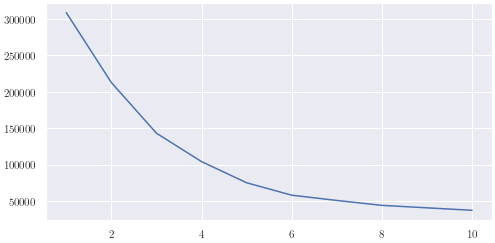

In [46]:
n_clusters = np.arange(1, 11, dtype=int)
wcss = []  # внутрикластерные суммы квадратов
for n in n_clusters:
    k_means = KMeans(n_clusters=n, random_state=0)
    k_means.fit(X)
    wcss.append(k_means.inertia_)

sns.lineplot(x=n_clusters, y=wcss);

По мере увеличения количества кластеров WCSS уменьшается. Неравномерное снижение WCSS приводит к образованию "локтевого" графика. Количество кластеров в локтевом образовании обычно указывает на оптимальное количество кластеров.

Судя по графику оптимальным количеством кластеров является одно из чисел: `3, 4, 5, 6` _(локоть не самый репрезентативный)_.
В качестве оптимального числа кластеров возьмем `5` _(просто потому что) \[если что потом скорректируем\]_.

Снова посмотрим на `annual_income` и `spending_score`, но уже с кластерным распределением:

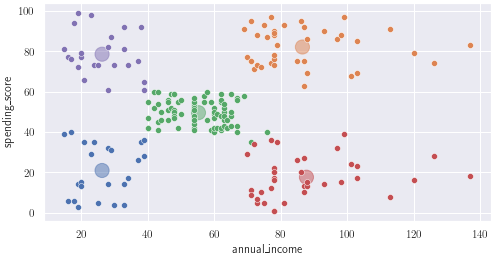

In [78]:
k_means = KMeans(n_clusters=5, random_state=0)
y_means = k_means.fit_predict(X)

fig, ax = plt.subplots()

ax.scatter(
    x=k_means.cluster_centers_[:, 1],
    y=k_means.cluster_centers_[:, 2],
    c=sns.color_palette(n_colors=k_means.n_clusters),
    s=200,
    alpha=0.5,
)

for i in range(k_means.n_clusters):
    sns.scatterplot(data=X[y_means == i], x='annual_income', y='spending_score', ax=ax)

Вроде бы получилось неплохо.

_Странно, что нет никаких видимых намеков на существование 3-его признака в векторе независимых переменных. Значит ли это, что возраст имеет хорошую корреляцию с одним из рассматриваемых признаков? Нет:_

In [79]:
X.corr().loc[['annual_income', 'spending_score'], 'age']

annual_income    -0.012398
spending_score   -0.327227
Name: age, dtype: float64

Посмотрим на полученное кластерное разделение в разрезе `age` - `spending_score`:

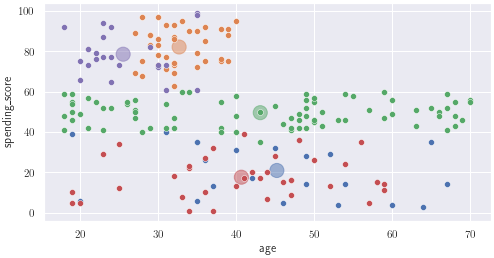

In [80]:
fig, ax = plt.subplots()

ax.scatter(
    x=k_means.cluster_centers_[:, 0],
    y=k_means.cluster_centers_[:, 2],
    c=sns.color_palette(n_colors=k_means.n_clusters),
    s=200,
    alpha=0.5,
)

for i in range(k_means.n_clusters):
    sns.scatterplot(data=X[y_means == i], x='age', y='spending_score', ax=ax)

На данном графике также прослеживаются некоторые зависимости. Однако, сравнивая с предыдущей проекцией, заметно, что `annual_income` вносит больший вклад в решение кластеризации, чем `age`.

Чтобы эффективно объяснить результат кластеризации для набора данных с тремя признаками, можно построить интерактивный график в трехмерном пространстве:

In [144]:
xs = X[y_means == 0]
ys = X[y_means == 1]
zs = X[y_means == 2]

colors = sns.color_palette(n_colors=k_means.n_clusters)

data = [go.Scatter3d(
    x=k_means.cluster_centers_[:, 0],
    y=k_means.cluster_centers_[:, 1],
    z=k_means.cluster_centers_[:, 2],
    mode='markers',
    marker={'size': 8, 'color': colors},
)]

for i in range(k_means.n_clusters):
    mask = y_means == i
    data.append(go.Scatter3d(
        x=X.loc[mask, 'age'],
        y=X.loc[mask, 'annual_income'],
        z=X.loc[mask, 'spending_score'],
        mode='markers',
        marker={'size': 4, 'color': [colors[i]] * len(mask), 'opacity': 0.8},
        name=i,
    ))

layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(xaxis_title='age', yaxis_title='annual income', zaxis_title='spending score'),
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

Теперь к характеристике групп можно добавить возраст: (люди с)
- низкими доходами и низкой долей трат, все возраста
- низкими доходами и высокой долей трат, <40 лет
- средними доходами и средней долей трат, все возраста
- высокими доходами и низкой долей трат, все возраста
- высокими доходами и высокой долей трат, <40 лет

Возможно распределение по кластерам можно улучшить, увеличив число кластеров. Например, людей со средними доходами и тратами разделить по возрастному признаку.

Для оценки оптимального числа кластеров воспользуемся метриками `silhouette_score`, `calinski_harabasz_score`.


In [217]:
param_grid = [{
    'n_clusters': np.arange(4, 13, dtype=int)
}]

search = GridSearchCV(
    KMeans(random_state=0),
    param_grid,
    scoring={
        'silhouette_score': metrics.make_scorer(metrics.silhouette_score),
        'calinski_harabasz_score': metrics.make_scorer(metrics.calinski_harabasz_score),
    },
    refit='silhouette_score',
    cv=[(slice(None), slice(None))],  # отключаем кросс-валидацию
    n_jobs=4,
)

In [218]:
search.fit(X, X);

In [219]:
score_1 = 'mean_test_calinski_harabasz_score'
score_2 = 'mean_test_silhouette_score'

report = pd.DataFrame(search.cv_results_)
report = report[['param_n_clusters', score_1, score_2, 'mean_fit_time', 'mean_score_time']]
report

,param_n_clusters,mean_test_calinski_harabasz_score,mean_test_silhouette_score,mean_fit_time,mean_score_time
0,4,127.983829,0.405463,0.032108,0.134917
1,5,151.043860,0.444286,0.041088,0.131832
2,6,166.720493,0.452344,0.034100,0.123917
3,7,162.285204,0.441281,0.288109,0.119204
4,8,163.580629,0.428097,0.196001,0.009106
5,9,156.155088,0.401263,0.198002,0.038105
6,10,152.264262,0.379098,0.261106,0.008998
7,11,149.695686,0.377305,0.137097,0.008001
8,12,146.746485,0.353370,0.117100,0.009000


С увеличением числа кластеров увеличивается время обучения и время предсказания модели.

С метриками `silhouette_score` и `calinski_harabasz_score` не все так очевидно - нет линейной зависимости от числа кластеров. Далее попробуем выбрать оптимальное число кластеров, основываясь на взаимосвязи данных метрик.

По графику видно, что метрики имеют общую тенденцию зависимости от числа кластеров. Оптимальной точкой является число кластеров равное `6`.

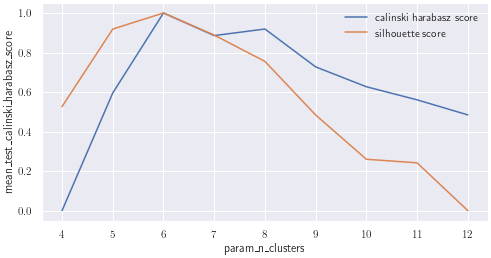

In [220]:
data = report.copy()
data.loc[:, [score_1, score_2]] = MinMaxScaler().fit_transform(data[[score_1, score_2]])

ax = sns.lineplot(data=data, x='param_n_clusters', y=score_1)
sns.lineplot(data=data, x='param_n_clusters', y=score_2, ax=ax)
ax.legend(['calinski harabasz score', 'silhouette score']);

Визуализируем результат кластеризации с оптимальным количеством кластеров:

In [221]:
k_means = KMeans(n_clusters=6, random_state=0)
y_means = k_means.fit_predict(X)

xs = X[y_means == 0]
ys = X[y_means == 1]
zs = X[y_means == 2]

colors = sns.color_palette(n_colors=k_means.n_clusters)

data = [go.Scatter3d(
    x=k_means.cluster_centers_[:, 0],
    y=k_means.cluster_centers_[:, 1],
    z=k_means.cluster_centers_[:, 2],
    mode='markers',
    marker={'size': 8, 'color': colors},
)]

for i in range(k_means.n_clusters):
    mask = y_means == i
    data.append(go.Scatter3d(
        x=X.loc[mask, 'age'],
        y=X.loc[mask, 'annual_income'],
        z=X.loc[mask, 'spending_score'],
        mode='markers',
        marker={'size': 4, 'color': [colors[i]] * len(mask), 'opacity': 0.8},
        name=i,
    ))

layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(xaxis_title='age', yaxis_title='annual income', zaxis_title='spending score'),
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

Как и предполагалось введение нового кластера позволило уточнить группу людей со средними доходами и расходами в разрезе возраста.


**Вывод:** "Метод локтя" не позволяет с полной степенью объективности оценить оптимальное количество кластеров, однако является простым и наглядным методом для локализации отрезка с потенциальным оптимальным значением кластеров. Метрики Силуэт (`silhouette_score`) и индекс Калински-Харабаса (`calinski_harabasz_score`) имеют пиковый характер (в отличие от "мягкого" графика "локтя") и хорошую корреляцию, что позволяет точно определить оптимальное количество кластеров.